# Initialization

## Install Packages

In [ ]:
!pip install PyMaxflow

## Imports

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import maxflow
from scipy.spatial.distance import cosine, euclidean
from skimage.segmentation import watershed, mark_boundaries
from scipy import ndimage
from sklearn.metrics import confusion_matrix, jaccard_score
import warnings
warnings.filterwarnings("ignore")

## Config

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

## Utils

In [ ]:
def visualize_watershed_mean_color(image, labels):
    vis_image = np.zeros_like(image)
    for lbl in np.unique(labels):
        mask = labels == lbl
        mean_color = np.mean(image[mask], axis=0)
        vis_image[mask] = mean_color
    return mark_boundaries(vis_image, labels, color=(1, 1, 0))

# Implementation

## Model

In [ ]:
class DeepIterativeGraphCutVGG:
    def __init__(self, device=DEVICE):
        self.device = device
        self.feature_extractor = models.vgg19(pretrained=True).features.to(self.device)
        self.feature_extractor.eval()

        self.saliency_model = models.detection.maskrcnn_resnet50_fpn(pretrained=True).to(self.device)
        self.saliency_model.eval()

        self.vgg_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        
        self.saliency_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
        ])

    def get_saliency_seeds(self, image_rgb):
        input_tensor = self.saliency_transform(image_rgb).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            prediction = self.saliency_model(input_tensor)[0]

        if len(prediction['masks']) > 0:
            fg_prob = prediction['masks'][0, 0].cpu().numpy()
        else:
            fg_prob = np.zeros((256, 256))
            fg_prob[80:176, 80:176] = 1.0

        fg_prob = cv2.resize(fg_prob, (image_rgb.shape[1], image_rgb.shape[0]))

        fg_seeds = fg_prob > 0.85
        bg_seeds = fg_prob < 0.15
        
        return fg_prob, fg_seeds, bg_seeds

    def apply_watershed(self, image_rgb):
        blurred = cv2.GaussianBlur(image_rgb, (5, 5), 0)
        gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)

        grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        gradient = np.sqrt(grad_x**2 + grad_y**2)

        markers = np.zeros_like(gray, dtype=np.int32)
        step = 15
        marker_id = 1
        for y in range(step // 2, gray.shape[0], step):
            for x in range(step // 2, gray.shape[1], step):
                markers[y, x] = marker_id
                marker_id += 1

        labels = watershed(gradient, markers, compactness=0.1)
        return labels

    def get_adjacency_list(self, labels):
        edges = set()
        horiz = np.c_[labels[:, :-1].ravel(), labels[:, 1:].ravel()]
        vert = np.c_[labels[:-1, :].ravel(), labels[1:, :].ravel()]
        for pair in np.vstack((horiz, vert)):
            if pair[0] != pair[1]:
                edges.add((min(pair[0], pair[1]), max(pair[0], pair[1])))
        return list(edges)

    def extract_combined_features(self, image_rgb, labels):
        input_tensor = self.vgg_transform(image_rgb).unsqueeze(0).to(self.device)

        with torch.no_grad():
            x = input_tensor
            for i in range(16):
                x = self.feature_extractor[i](x)
            deep_features = x

        resized_tensor = F.interpolate(deep_features, size=(image_rgb.shape[0], image_rgb.shape[1]), mode='bilinear', align_corners=False)
        feature_map = resized_tensor[0].cpu().numpy()
        feature_map = np.transpose(feature_map, (1, 2, 0))

        region_features = {}
        unique_labels = np.unique(labels)
        for lbl in unique_labels:
            mask = (labels == lbl)
            deep_f = np.mean(feature_map[mask], axis=0)
            color_f = np.mean(image_rgb[mask], axis=0) / 255.0
            region_features[lbl] = {'deep': deep_f, 'color': color_f}

        return region_features

    def iterated_region_merging(self, labels, region_features, adj_list, fg_seeds, bg_seeds, lambda_param=80):
        unique_labels = np.unique(labels)
        node_status = {lbl: -1 for lbl in unique_labels}

        for lbl in unique_labels:
            mask = (labels == lbl)
            if np.sum(fg_seeds[mask]) / np.sum(mask) > 0.5:
                node_status[lbl] = 1
            elif np.sum(bg_seeds[mask]) / np.sum(mask) > 0.5:
                node_status[lbl] = 0

        neighbors = {lbl: [] for lbl in unique_labels}
        for u, v in adj_list:
            neighbors[u].append(v)
            neighbors[v].append(u)

        iteration = 0
        while iteration < 5:
            iteration += 1
            active_nodes = set()
            for lbl, status in node_status.items():
                if status != -1:
                    active_nodes.add(lbl)
                    for nxt in neighbors[lbl]:
                        if node_status[nxt] == -1:
                            active_nodes.add(nxt)

            active_nodes = list(active_nodes)
            if not active_nodes:
                break

            g = maxflow.Graph[float]()
            node_ids = {lbl: g.add_nodes(1)[0] for lbl in active_nodes}

            for u, v in adj_list:
                if u in active_nodes and v in active_nodes:
                    dist_deep = cosine(region_features[u]['deep'], region_features[v]['deep'])
                    dist_color = euclidean(region_features[u]['color'], region_features[v]['color'])

                    dist_total = (0.7 * dist_deep) + (0.3 * dist_color)
                    weight = np.exp(-dist_total * lambda_param)
                    g.add_edge(node_ids[u], node_ids[v], weight, weight)

            for lbl in active_nodes:
                if node_status[lbl] == 1:
                    g.add_tedge(node_ids[lbl], 1000.0, 0.0)
                elif node_status[lbl] == 0:
                    g.add_tedge(node_ids[lbl], 0.0, 1000.0)
                else:
                    g.add_tedge(node_ids[lbl], 0.0, 0.0)

            g.maxflow()

            changed = False
            for lbl in active_nodes:
                if node_status[lbl] == -1:
                    segment = g.get_segment(node_ids[lbl])
                    node_status[lbl] = 1 if segment == 0 else 0
                    changed = True

            if not changed or all(v != -1 for v in node_status.values()):
                break

        final_mask = np.zeros_like(labels, dtype=np.uint8)
        for lbl, status in node_status.items():
            if status == 1:
                final_mask[labels == lbl] = 1
                
        num_labels, labels_cc, stats, _ = cv2.connectedComponentsWithStats(final_mask, connectivity=8)
        if num_labels > 2:
            largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
            final_mask = (labels_cc == largest_label).astype(np.uint8)

        return final_mask

    def run(self, image_path):
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        fg_prob, fg_seeds, bg_seeds = self.get_saliency_seeds(image_rgb)
        labels = self.apply_watershed(image_rgb)
        adj_list = self.get_adjacency_list(labels)
        region_features = self.extract_combined_features(image_rgb, labels)

        final_mask = self.iterated_region_merging(labels, region_features, adj_list, fg_seeds, bg_seeds)
        return image_rgb, fg_prob, labels, final_mask

## Dataset

In [ ]:
dataset = torchvision.datasets.OxfordIIITPet(root='./data', download=True, target_types='segmentation')

## Inference &  Results

⬇️ در حال دانلود دیتاست عمومی (Oxford-IIIT Pet) - کمی صبر کنید...
⚙️ در حال بارگذاری مدل‌های عمیق (VGG16 و Mask R-CNN)...
🚀 در حال پردازش 5 تصویر با الگوریتم VGG16 + Graph Cuts...
تصویر 1 -> امتیاز (IoU): 0.8275 | حساسیت (TPF): 0.8579
تصویر 2 -> امتیاز (IoU): 0.6880 | حساسیت (TPF): 0.8235
تصویر 3 -> امتیاز (IoU): 0.8415 | حساسیت (TPF): 0.8535
تصویر 4 -> امتیاز (IoU): 0.7157 | حساسیت (TPF): 0.7172
تصویر 5 -> امتیاز (IoU): 0.8067 | حساسیت (TPF): 0.8236


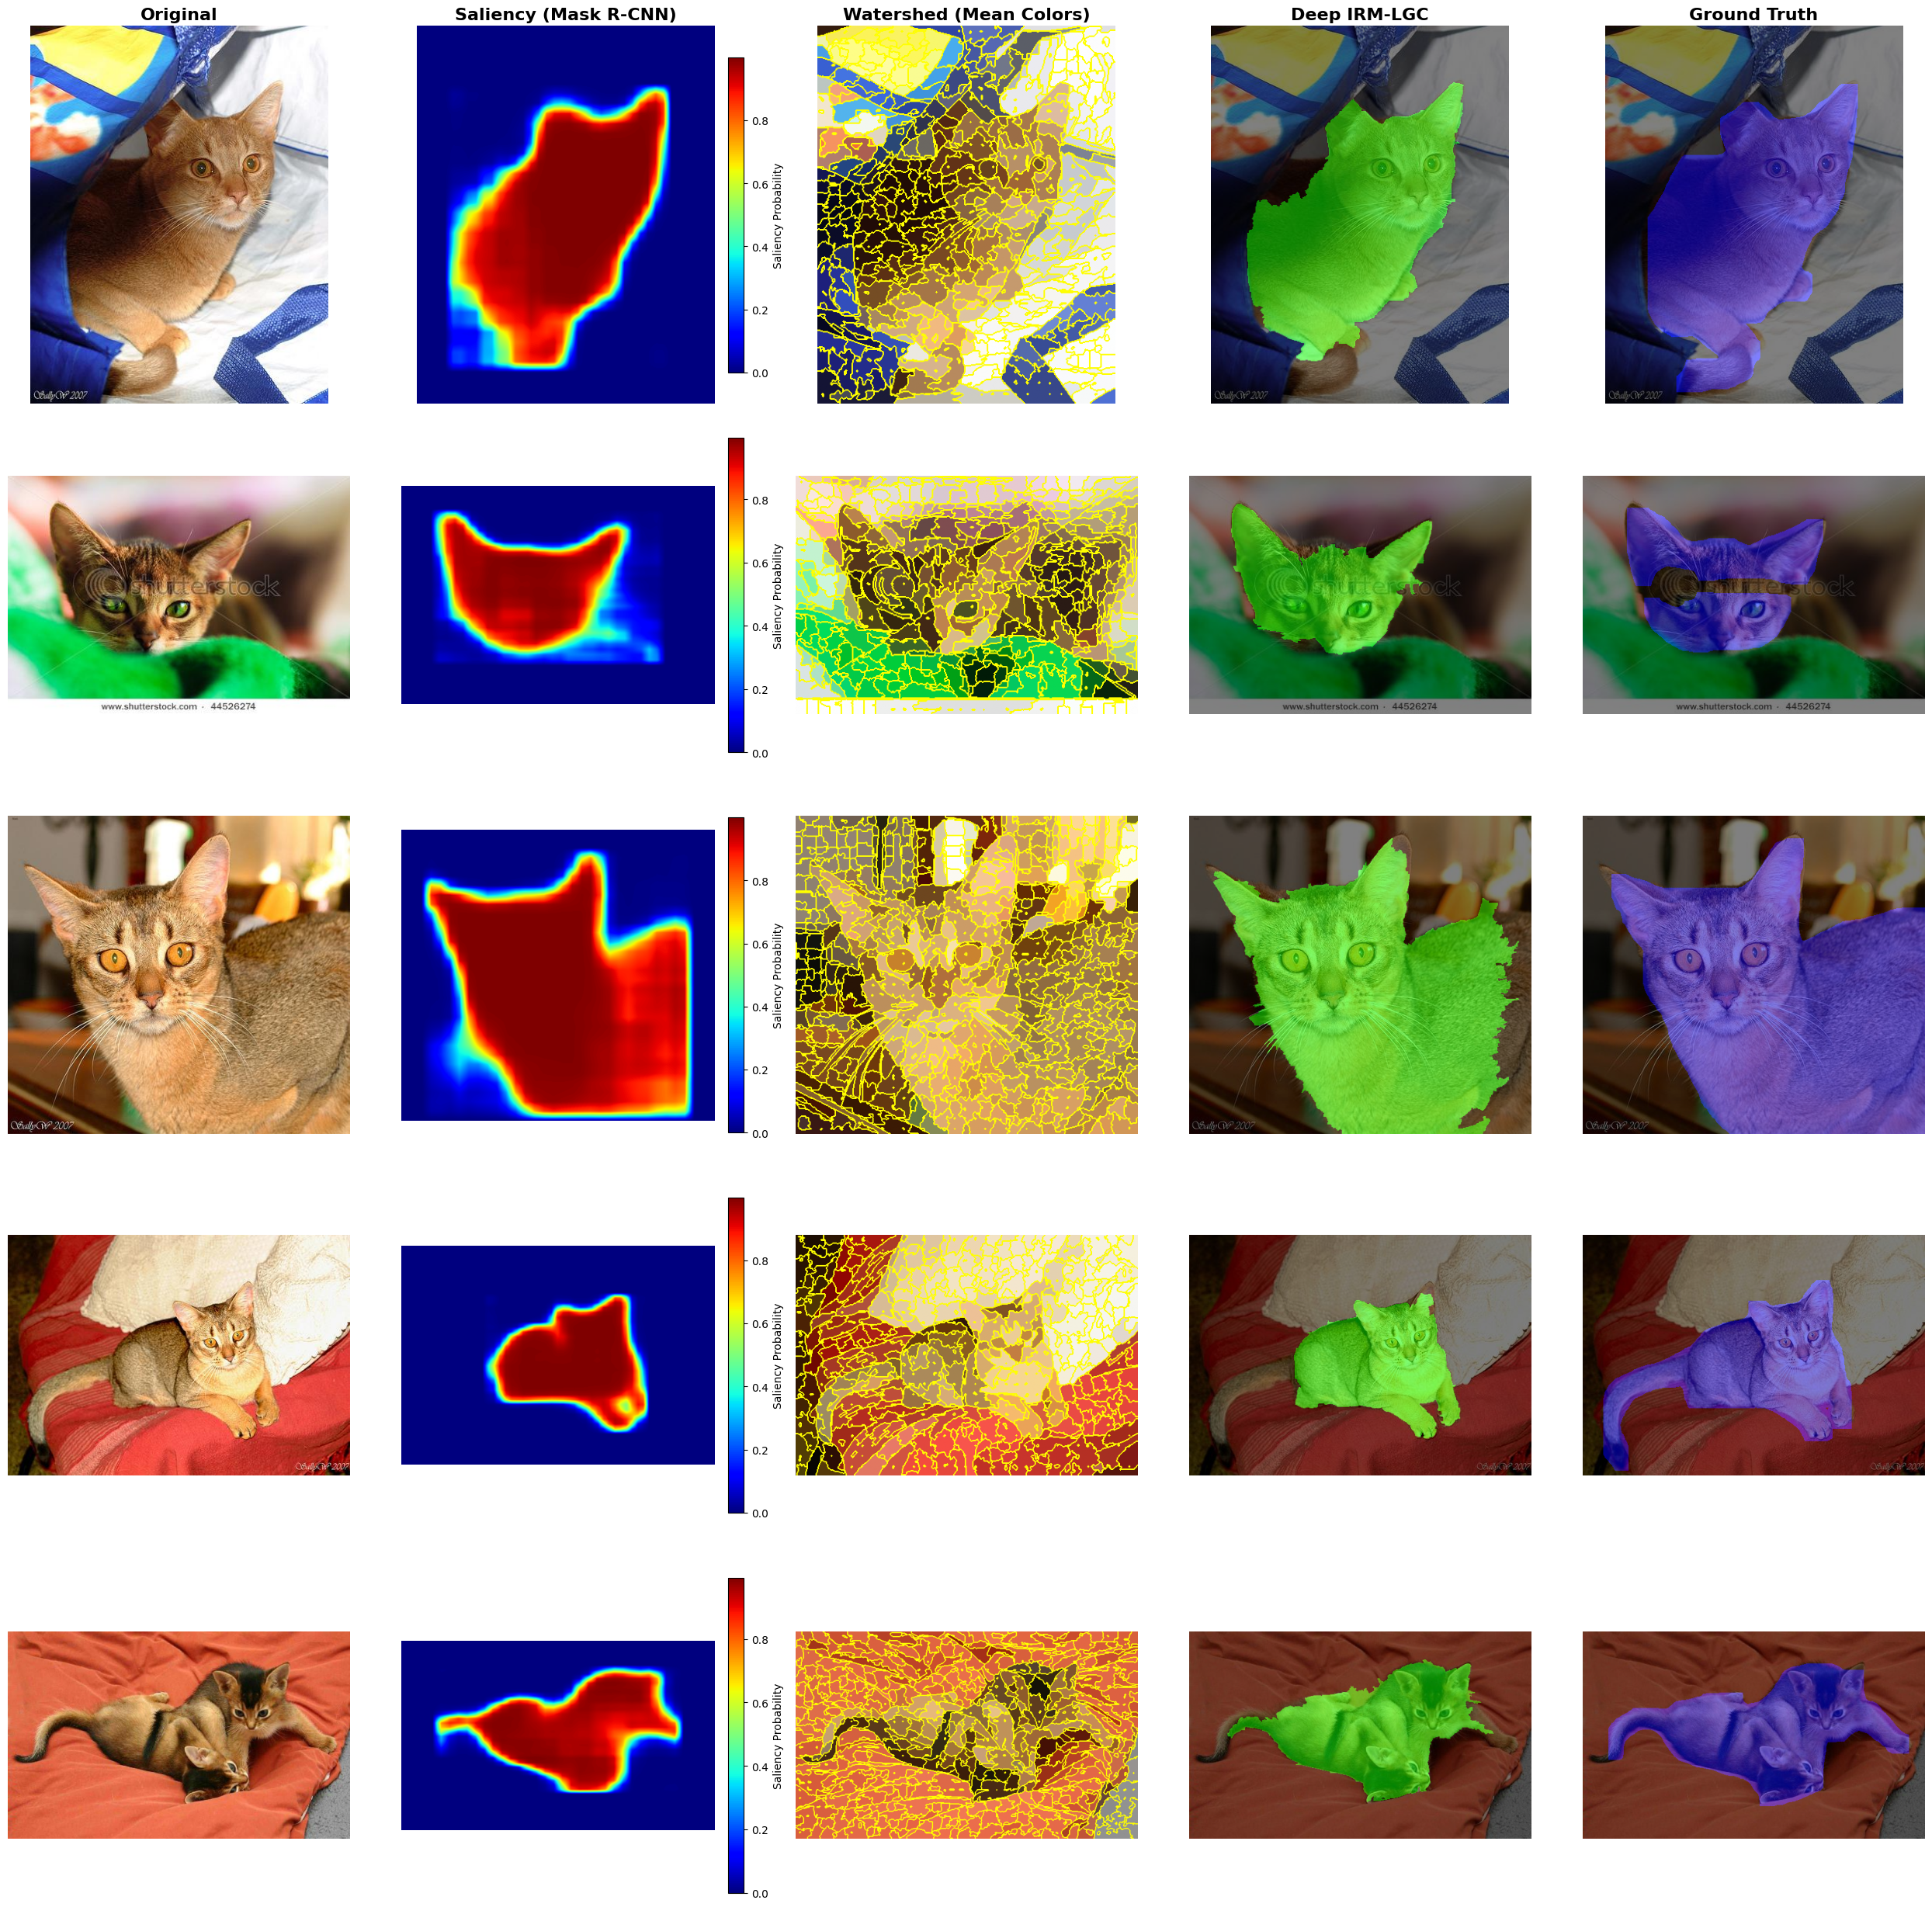

In [ ]:
pipeline = DeepIterativeGraphCutVGG(device=DEVICE if torch.cuda.is_available() else 'cpu')

num_samples = 5
fig, axs = plt.subplots(num_samples, 5, figsize=(25, 5 * num_samples))
titles = ['Original', 'Saliency (Mask R-CNN)', 'Watershed (Mean Colors)', 'Deep IRM-LGC', 'Ground Truth']

print(f"Processing {num_samples} images with VGG16 + Graph Cuts...")

for idx in range(num_samples):
    img_pil, mask_pil = dataset[idx]
    img_path = f'general_test_{idx}.jpg'
    img_pil.convert("RGB").save(img_path)

    mask_np = np.array(mask_pil)
    gt_mask = (mask_np == 1).astype(np.uint8)

    image_rgb, saliency_map, watershed_labels, final_pred_mask = pipeline.run(img_path)

    gt_mask_resized = cv2.resize(gt_mask, (final_pred_mask.shape[1], final_pred_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

    kernel_20x20 = np.ones((20,20),np.uint8)
    grown_gt_mask = cv2.dilate(gt_mask_resized, kernel_20x20, iterations = 1)

    cm = confusion_matrix(grown_gt_mask.flatten(), final_pred_mask.flatten(), labels=[0, 1])
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
    else:
        tn, fp, fn, tp = 0, 0, 0, 0 
        
    tpf_score = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    iou_score = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0.0

    print(f"image {idx+1} -> (IoU): {iou_score:.4f} | (TPF): {tpf_score:.4f}")

    watershed_vis = visualize_watershed_mean_color(image_rgb, watershed_labels)

    images = [image_rgb, saliency_map, watershed_vis, final_pred_mask, grown_gt_mask]
    cmaps = [None, 'jet', None, 'gray', 'gray']

    for col in range(5):
        ax = axs[idx, col]
        if titles[col] == 'Deep IRM-LGC':
            ax.imshow(image_rgb)
            predicted_overlay = np.zeros_like(image_rgb)
            predicted_overlay[final_pred_mask == 1] = [0, 255, 0] 
            ax.imshow(predicted_overlay, alpha=0.5) 
        elif titles[col] == 'Ground Truth':
            ax.imshow(image_rgb)
            ground_truth_overlay = np.zeros_like(image_rgb)
            ground_truth_overlay[grown_gt_mask == 1] = [0, 0, 255] 
            ax.imshow(ground_truth_overlay, alpha=0.5) 
        elif cmaps[col]:
            im = ax.imshow(images[col], cmap=cmaps[col])
            if titles[col] == 'Saliency (Mask R-CNN)': 
                cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
                cbar.set_label('Saliency Probability')
        else:
            ax.imshow(images[col])

        if idx == 0:
            ax.set_title(titles[col], fontsize=16, fontweight='bold')
        ax.axis('off')

plt.tight_layout()
plt.show()